### AWS SageMaker XGBoost Classification Training Models with cross validation Experiment (Features and Parameters research)

Purpose: Based on the configured list of features and/or parameters train several models to compare results. Each model is a set of cross validation folds.

The idea is to do a **deep**  model comparison with the same method (XGBoost Classification), target variable and dataset but different sets of features and/or parameters. 

The models can be trained in parallel and even with a large dataste, the result is available relatively soon comparing to sequntial run on a local server.

The output is not just a model and score (ROC-AUC) but also feature importance, test dataset evaluation score and training/validation errors to analyze overfitting.

OpenSource XGBoost is used in the script but it can be easily replaced with SageMaker built-in XGBoost (except returning feature importance, test dataset evaluatin scores and training/validation errors to analyze overfitting). Standard SageMaker approach is used for built-in models to get and analyze addition information. See model debugging.

Main steps:

1. Experiment configuration. Instead of hardcoding datafile name, target variable, featuresets and parameters sets directly in the code I use an Excel file. Each tab with a predefined name contains featuresets for each model or parameter sets, etc. At the end, the code records the results back into the same excel file. Excel is used as an UI to easily configure experiment. 

AWS SageMaker Experiment is used also but I did not find it's very useful to track the featuresets and process and visaulaize the results (available in SageMaker notebook).  I need to average data before comparing and take into account sem.

2. Preparing training and validation datasets in configured number of folds (num_folds) - data preprocessing - in S3 in a format suitable for AWS Sagemaker. SKLearnProcessor and a processing job are used to create all datasets for all models in one process but the same can be done directly in the script and only the result can be moved to S3. If the datasets can be re-used from a previous experiment, only S3 location to the files can be configured instead.
Usually, testing different featuretests requires creation individual datasets per testing model and different parameters can be tested on the same dataset.


3. Training each model is done in parallel. The number of simultaneously running training jobs is contolled by a parameter (MaxNumOfRunningModels).

4. Extracting results, visualization, performing t-test and saving to an experiment log file. This is done for averaged results from all folds per model. 


Known issues:
1. Warnings after upgrading SageMaker to version 2:
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
Looks like warnings from XGBoost open-source estimator. No clear information about the parameters
2. All models artifacts are saved into output_path provided as a parameter to the estimator (expected only model.tar.gz) except source/sourcedir.tar.gz which is saved into toot of a bucket from output_path. Previously everything except model.tar.gz was saved into default bucket

In [1]:
temp_folder='/home/kate/Research/YearBuilt/Notebooks/Experiments_v2/tmp/'
#Experiment_name must NOT contain underscore (_)
Experiment_name='bf'
#Experiments log file
Experiments_file='/home/kate/Research/YearBuilt/Experiments/DevExperiments.xlsx'
#AllExperiments_tab is a table with a list of all experiments included in the log
#Mandatory columns: Experiment (Experiment_name), Dataset(data file name), Target(target column name from Dataset)
#The rest of the columns are not use in the code below. I usually add in a free form: objective,status,result,notebook name used to conduct the experiment
AllExperiments_tab='Experiments'
#Experiment configuration:
#1.Experiment_Features_tab: differenet datasets to try
#each line in the tab contains a model name and set of features to built a dataset for SageMaker
#a feature can be an exact column name from the Dataset column in AllExperiments_tab or a calculation based on exact column names and eval pandas function
#if the experiment objective is to try different parameters sets, all models (if more then 1) can have the same feature sets.
Experiment_Features_tab='%s Features'%Experiment_name
#2. Alternatively a set of data files with preprocessed data in S3 can be provided in a form:
#Model,Training_data,Validation_data[, Testing_data, Testing_labels]
Experiment_InputData_tab='%s InputData'%Experiment_name
#3. Experiment_Params_tab: each line in the tab contains a model name and set of XGBoost parametersto apply to a model
#the set of models should be consistent in Experiment_Features_tab and Experiment_Params_tab
#parameters can be the same for all models or specific in each model
Experiment_Params_tab='%s Params'%Experiment_name

#Trial names in AWS Sage Maker experiment
Trial_name_preprocessing='%s-PreparingTrainValidData'%Experiment_name
Trial_name_training='%s-TrainingModels'%Experiment_name

#everything stored in
bucket='kdproperty'

path_to_data='Data'
path_to_training_data='Data/Experiments/%s/training'%Experiment_name
path_to_validation_data='Data/Experiments/%s/validation'%Experiment_name
path_to_testing_data='Data/Experiments/%s/testing'%Experiment_name
path_to_testing_labels='Data/Experiments/%s/labels'%Experiment_name
path_to_configuration='Config'
path_to_models='Models/Experiments/%s'%Experiment_name

#preprocessing parameters
split_year='2020'

#number of folds for CV
num_folds='10'

#level of details returning from CV
#any Y return models from a best iteration
#FeatureImportance Y/N
GetFIFlg='Y'
#Scores for Test data (should be provided in fit "test" input) Y/N
GetTestScoreFlg='Y'
#Prediction of Test data (should be provided in fit "test" input) Y/N
GetTestPredFlg='N'  


#Confidence level for t-test
confidence_level=0.05

preprocessing_instance_type='ml.t3.large'
preprocessing_instance_count=1

#Training parameters
training_instance_type='ml.c5.xlarge'
training_instance_count=1

#How many simultaneously running training jobs we want to see in the system
MaxNumOfRunningModels = 30
#when a job is completes/failed or stopped a new one can be added Jobs status is checked periodically
check_training_job_every_sec=10

#What to do with th2 experiment (rest of running jobs) if a training job failed or stopped
StopOnFailedModel = True

In [2]:
import sys
import time
import os

import re

import pandas as pd
import numpy as np

import boto3

import s3fs
import tarfile

from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

import sagemaker
from sagemaker.session import TrainingInput
from sagemaker.xgboost.estimator import XGBoost

from sagemaker.analytics import ExperimentAnalytics

import matplotlib.pyplot as plt
import scipy.stats as stats



In [3]:
#should be run as a first step
#role arn is used when run from a local machine
sagemaker_execution_role = 'arn:aws:iam::757107622481:role/service-role/AmazonSageMaker-ExecutionRole-20200819T131882'

region = boto3.session.Session().region_name
sagemaker_session = sagemaker.session.Session()
s3 = s3fs.S3FileSystem()

## Experiment
Experiment is configured in an experiment log file (Excel file, in my case,  in different tabs)

1. Reading an experiment configuration (Experiment_name) from an experiment log file (Experiments_file). Target and Dataset columns in AllExperiments_tab contain data file name used and target column

In [4]:
experiments = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=AllExperiments_tab)

In [5]:
target=experiments[experiments['Experiment']==Experiment_name]['Target'].values[0]
print('Target of models in %s experiment is %s'%(Experiment_name,target))
data_file=experiments[experiments['Experiment']==Experiment_name]['Dataset'].values[0]
print('Datafile used in %s experiment is %s'%(Experiment_name,data_file))

Target of models in bf experiment is hasclaim_water
Datafile used in bf experiment is dwelling_basedata_v4.csv


2. Models based on individual datasets to be created, trained and compared in the experiment (Experiment_Features_tab) is a table with first column Model name (should be unique) and next columns [1:51] features to train the model. Feature is the exact column name from the dataset or a calculation based on exact column names and eval pandas function

This configuration will be used to preprocess data and also need to be moved to S3 in csv format for easy reading in a preprocessing script if we use AWS SKLearnProcessor/job/instances

In [6]:
model_features = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Features_tab)
model_features  

,Model,F1,F2,F3,F4
0,BaseModel,yearbuilt,cova_deductible,sqft,NaN
1,Limit,yearbuilt,cova_deductible,sqft,cova_limit
2,Usage,yearbuilt,cova_deductible,sqft,usagetype_encd
3,Landlord,yearbuilt,cova_deductible,sqft,landlordind
4,WaterScore,yearbuilt,cova_deductible,sqft,water_risk_3_blk
5,Constr,yearbuilt,cova_deductible,sqft,constructioncd_encd
6,Prot,yearbuilt,cova_deductible,sqft,protectionclass
7,MultiPol,yearbuilt,cova_deductible,sqft,multipolicyind
8,OtherPol,yearbuilt,cova_deductible,sqft,cnt_active_other_policies


In [62]:
#we may need to get mapping between f0 - fN features in the dataset and feature importance output based on Modelname
def GetMap(model):
    feature_map={}
    df=model_features[model_features['Model']==model].loc[:, model_features.columns != 'Model']
    for i,c in enumerate(df.columns):
        feature_map['f%s'%i]=df[c].values[0]
    return feature_map

2a.Preprocessed data may already exists in an S3. Experiment configuration can provide the list of files per model. In this case (len(preprocessed_data)==0) the code skips all steps to preprocess data

In [8]:
try:
    preprocessed_data = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_InputData_tab)
except:
    preprocessed_data = pd.DataFrame()

In [9]:
preprocessed_data

""


2b.Saving into S3 models configurations (sets of features) to be used in data preprocessing

In [10]:
if len(preprocessed_data)==0:
    Model_Config_file='%s.csv'%Experiment_name
    Models_Config_path = os.path.join(temp_folder, Model_Config_file) 

    model_features.to_csv(Models_Config_path, header=True, index=False)


    input_code = sagemaker_session.upload_data(
        Models_Config_path,
        bucket=bucket,
        key_prefix=path_to_configuration
    )

3. Model params to be used in training is a table with first column Model name (should be unique and corresponds to models in Experiment_Features_tab) and next columns are XGBoost parameters
In a general case, all models can have the same parameters

In [11]:
model_params = pd.read_excel(open(Experiments_file, 'rb'), sheet_name=Experiment_Params_tab)
model_params

,Model,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,subsample,max_depth,num_round
0,BaseModel,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000
1,Limit,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000
2,Usage,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000
3,Landlord,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000
4,WaterScore,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000
5,Constr,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000
6,Prot,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000
7,MultiPol,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000
8,OtherPol,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000


4.Verification if we have the same set of models in both configurations

In [12]:
models_from_model_features=model_features['Model'].tolist()
models_from_model_params=model_params['Model'].tolist()
if len([x for x in models_from_model_features if x not in models_from_model_params])!=0:
    raise Exception('Different set of models in featuresets and parametersets!')
if len(preprocessed_data)>0:
    models_from_preprocessed_data=preprocessed_data['Model'].tolist()
    if len([x for x in models_from_preprocessed_data if x not in models_from_model_params])!=0:
        raise Exception('Different set of models in input data and parametersets!')

5.Creating experiments and trials in SageMaker

In [13]:
#sys.path.append('/home/kate/Research/YearBuilt/Notebooks/Experiments')
import ExperimentsUtils as eu

In [14]:
eu.cleanup_experiment(Experiment_name)
eu.create_experiment(Experiment_name)
eu.create_trial(Experiment_name,Trial_name_preprocessing)
eu.create_trial(Experiment_name,Trial_name_training)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


## Data preprocessing

1. We may not need an AWS SKLearnProcessor/job/instances for relatively small and medium datasets (unless our data are already in S3 and it takes time and money to download)
What's important is to save the prepared datasets in a predefined S3 location to be used in training.
In a case of really huge datasets and instensive, time consuming preprocessing, a separate SKLearnProcessor/job for each model can be created with more then 1 powerful instance.

Preprocessing script below reads the data from the input dataset, model configurations (desired featuresets), seprate 2020 (split_year) as a test dataset (not used in the experiment, because the data may be not complete developed in the year) and split the rest of the data to training and validation folds. 

Training and validation datasets are saved in AWS SageMaker form (first column is a target, no header) in csv format. The location and filenames are based on model names: folder name is a model name and file names also contain a model name.

In [15]:
%%writefile preprocessingStratifiedKFold_for_all_models.py

#Training and Validation dataset for SageMaker are the same structure: no headers, the first column is a target and the rest are features


import argparse
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

if __name__=='__main__':
    
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_file', type=str)
    parser.add_argument('--split_year', type=int)   
    parser.add_argument('--num_folds', type=int)      
    parser.add_argument('--target', type=str)      
    parser.add_argument('--config_file', type=str)     
    args, _ = parser.parse_known_args()    
    print('Received arguments {}'.format(args))
    
    target_column=args.target
    input_data_path = os.path.join('/opt/ml/processing/input', args.data_file)
    config_data_path = os.path.join('/opt/ml/processing/config', args.config_file)
    


    
   
    
    print('Reading input data from {}'.format(input_data_path))
    dataset = pd.read_csv(input_data_path, error_bad_lines=False, index_col=False)
    dataset_test=dataset[(dataset.cal_year == args.split_year)]
    dataset=dataset[(dataset.cal_year < args.split_year)]    
    

    print('Reading config data from {}'.format(config_data_path))
    models = pd.read_csv(config_data_path, error_bad_lines=False, index_col=False) 
    
           
    #StratifiedKFold
    kfold =args.num_folds 
    skf = StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    
    #iterating thru config file with models and featureset
    for index, row in models.iterrows():
        model=row['Model']
        print (index, ': Creating datasets for model %s'%model)
        featureset=row[1:51].tolist()
        featureset=[x for x in featureset if str(x) != 'nan']
        print(','.join(featureset))
        
        #creating dataset for a model according to configured dataset
        X = pd.DataFrame()
        X_test = pd.DataFrame()  
        for f in featureset:
            X[f]=dataset.eval(f)
            X_test[f]=dataset_test.eval(f)             
        y=dataset.eval(target_column)    
        y_test=dataset_test.eval(target_column) 

        #Testing data starts from y_test because they are read in XGBoost processing script to DMatrix amd first column is separated anyway
        #Without the column the script can not predict
        print('Testing data...')
        test_data_output_path = '/opt/ml/processing/output/testing_data/%s/'%model              
        if not os.path.exists(test_data_output_path):
            os.makedirs(test_data_output_path)       
        test_data_output_path = os.path.join(test_data_output_path,  'testing_%s.csv'%(model))  
        test_dataset=pd.DataFrame({target_column:y_test}).join(X_test)
        test_dataset.to_csv(test_data_output_path, header=False, index=False)
        
        #The rest of teh data will be used in cv-fold as a whole and seprated to training/validation insode cv        
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            print(' fold: {}  of  {} : '.format(i+1, kfold))
            X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[test_index] 

            train_data_output_path = '/opt/ml/processing/output/training_data/%s/'%model              
            if not os.path.exists(train_data_output_path):
                os.makedirs(train_data_output_path)
            train_data_output_path_fold = os.path.join(train_data_output_path,  'fold_%s_training_%s.csv'%(model,i))
            
            validation_data_output_path = '/opt/ml/processing/output/validation_data/%s/'%model  
            if not os.path.exists(validation_data_output_path):
                os.makedirs(validation_data_output_path)            
            validation_data_output_path_fold = os.path.join(validation_data_output_path, 'fold_%s_validation_%s.csv'%(model,i))       
        
            training_dataset=pd.DataFrame({target_column:y_train}).join(X_train)
            training_dataset.to_csv(train_data_output_path_fold, header=False, index=False)
                                                   
            validation_dataset=pd.DataFrame({target_column:y_valid}).join(X_valid)   
            validation_dataset.to_csv(validation_data_output_path_fold, header=False, index=False)    

Overwriting preprocessingStratifiedKFold_for_all_models.py


In [16]:
if len(preprocessed_data)==0:
    data_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=sagemaker_execution_role,
                                     instance_type=preprocessing_instance_type,
                                     instance_count=preprocessing_instance_count)    
    data_processor.run(code='preprocessingStratifiedKFold_for_all_models.py',
                            inputs=[ProcessingInput(input_name='data',source='s3://%s/%s/%s'%(bucket,path_to_data,data_file),destination='/opt/ml/processing/input'),
            ProcessingInput(input_name='config',source='s3://%s/%s/%s'%(bucket,path_to_configuration,Model_Config_file),destination='/opt/ml/processing/config'),
                                   ],
                        outputs=[ProcessingOutput(output_name='training_data', source='/opt/ml/processing/output/training_data',destination='s3://%s/%s/'%(bucket,path_to_training_data)),                                 
                                 ProcessingOutput(output_name='validation_data', source='/opt/ml/processing/output/validation_data',destination='s3://%s/%s/'%(bucket,path_to_validation_data)),                                      
                                 ProcessingOutput(output_name='testing_data', source='/opt/ml/processing/output/testing_data',destination='s3://%s/%s/'%(bucket,path_to_testing_data))
                                ],
                        arguments=['--data_file',data_file,
                                 '--split_year',split_year,
                                 '--num_folds',num_folds,  
                                 '--target',target,                                    
                                 '--config_file',Model_Config_file],
                        experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name_preprocessing,
        'TrialComponentDisplayName' : '%s-%s'%(Trial_name_preprocessing,'-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())),},
                    wait=True
                     )
else:
    print('Data already preprocessed in S3')

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2021-02-14-17-34-11-190



Job Name:  sagemaker-scikit-learn-2021-02-14-17-34-11-190
Inputs:  [{'InputName': 'data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://kdproperty/Data/dwelling_basedata_v4.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://kdproperty/Config/bf.csv', 'LocalPath': '/opt/ml/processing/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-757107622481/sagemaker-scikit-learn-2021-02-14-17-34-11-190/input/code/preprocessingStratifiedKFold_for_all_models.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outpu

In [17]:
#in a case a previous step started preproceesin (nothing provided in InputData) Stop the execution if there is an issue with creating input data for the models
if len(preprocessed_data)==0:
    job_name=data_processor.jobs[-1].describe()['ProcessingJobName']
    if not(sagemaker_session.was_processing_job_successful(job_name)):
        raise Exception('Preprocessing job Failed!')    

2. Preprocessing output (training and validation datasets) is saved separately for each model and fold in a folder with the same name as a models name configured in the experiment

In [18]:
#was not tested with different feature sets (more then 1 row in model_feature)
#preprocessed_data=preprocessed_data[0:0]
if len(preprocessed_data)==0:
    j=0
    for index, row in model_features.iterrows():
        model=row['Model']
        folds_preprocessed_data = pd.DataFrame(columns=['Model','fold', 'Training_data', 'Validation_data', 'Testing_data'])
        for i in range(0,int(num_folds),1):
            train_input = 's3://%s/%s/%s/fold_%s_training_%s.csv'%(bucket,path_to_training_data,model,model,i)
            validation_input = 's3://%s/%s/%s/fold_%s_validation_%s.csv'%(bucket,path_to_validation_data,model,model,i)
            test_data = 's3://%s/%s/%s/testing_%s.csv'%(bucket,path_to_testing_data,model,model) 
            folds_preprocessed_data.loc[j]=[model, i,  train_input,validation_input,test_data]
            j=j+1
        folds_preprocessed_data = pd.merge(folds_preprocessed_data,model_features,on='Model', how='inner')
        preprocessed_data = pd.concat([preprocessed_data, folds_preprocessed_data], axis=0)
    #Saving into the Experiment log file names of created training and validation datasets in S3
    eu.SaveToExperimentLog(Experiments_file, '%s InputData'%Experiment_name, preprocessed_data)
preprocessed_data

,Model,fold,Training_data,Validation_data,Testing_data,F1,F2,F3,F4
0,BaseModel,0,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
1,BaseModel,1,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
2,BaseModel,2,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
3,BaseModel,3,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
4,BaseModel,4,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
...,...,...,...,...,...,...,...,...,...
5,OtherPol,5,s3://kdproperty/Data/Experiments/bf/training/O...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ot...,yearbuilt,cova_deductible,sqft,cnt_active_other_policies
6,OtherPol,6,s3://kdproperty/Data/Experiments/bf/training/O...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ot...,yearbuilt,cova_deductible,sqft,cnt_active_other_policies
7,OtherPol,7,s3://kdproperty/Data/Experiments/bf/training/O...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ot...,yearbuilt,cova_deductible,sqft,cnt_active_other_policies
8,OtherPol,8,s3://kdproperty/Data/Experiments/bf/training/O...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ot...,yearbuilt,cova_deductible,sqft,cnt_active_other_policies


## Model training

1. Custom script to train a model. It's requred for open-source SageMaker XGBoost container used further in the notebook. The script returns some additional information (feature importance, test dataset scores and train/validation errors) from training for custom processing. The custom output is saved in output.tar.gz.

In [19]:
%%writefile ModelTraining.py

#  Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  or in the "license" file accompanying this file. This file is distributed
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#  express or implied. See the License for the specific language governing
#  permissions and limitations under the License.
from __future__ import print_function

import argparse
import json
import logging
import os
import pandas as pd
import pickle as pkl

from sagemaker_containers import entry_point
from sagemaker_xgboost_container.data_utils import get_dmatrix
from sagemaker_xgboost_container import distributed

import xgboost as xgb

import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score

def _xgb_train(params, dtrain, evals, num_boost_round, early_stopping_rounds, model_dir, output_data_dir, GetFIFlg,GetTestScoreFlg,GetTestPredFlg, is_master):
    """Run xgb train on arguments given with rabit initialized.

    This is our rabit execution function.

    :param args_dict: Argument dictionary used to run xgb.train().
    :param is_master: True if current node is master host in distributed training,
                        or is running single node training job.
                        Note that rabit_run will include this argument.
    """
    progress = dict()
    booster = xgb.train(params=params,
                        dtrain=dtrain,
                        evals=evals,
                        maximize=True,
                        num_boost_round=num_boost_round,
                        early_stopping_rounds=early_stopping_rounds,
                        evals_result=progress,
                        verbose_eval=100)
    
    print('Eval results')    
    train_error=progress['train']['auc']
    eval_error=progress['validation']['auc']
    results_pd=pd.DataFrame({'train':train_error,'valid':eval_error},columns=['train','valid'])
    
    
    #feature importance
    if GetFIFlg=='Y':
        fi_weight =booster.get_score(importance_type='weight')
        fi_gain = booster.get_score(importance_type='gain')
        fi_cover= booster.get_score(importance_type='cover')
        fi_weight_pd = pd.DataFrame(fi_weight.items(),columns=['feature','weight'])
        fi_gain_pd = pd.DataFrame(fi_gain.items(),columns=['feature','gain'])
        fi_cover_pd = pd.DataFrame(fi_cover.items(),columns=['feature','cover'])
        fi_pd=pd.merge(fi_gain_pd, fi_weight_pd, on='feature', how='inner')
        fi_pd=pd.merge(fi_pd, fi_cover_pd, on='feature', how='inner')

    #Prediction on test data ...
    if 'Y' in (GetTestScoreFlg,GetTestPredFlg):
        df_prediction=pd.DataFrame()
        df_prediction['actual']=dtest.get_label()
        df_prediction['pred']=booster.predict(dtest)
   
        #Test scores from test prediction   
        df_score = pd.DataFrame()
        df_score['roc-auc-test']=[roc_auc_score(df_prediction['actual'], df_prediction['pred'])]
    
    if is_master:
        model_location = model_dir + '/xgboost-model'
        pkl.dump(booster, open(model_location, 'wb'))
        logging.info("Stored trained model at {}".format(model_location))
        
        if not os.path.exists(output_data_dir):
            os.makedirs(output_data_dir)

        result_location = os.path.join(output_data_dir, 'eval_results.csv')
        print('Saving eval results at {}'.format(result_location))
        logging.info('Saving eval results at {}'.format(result_location))
        results_pd.to_csv(result_location, header=True, index=False)
        
        if GetFIFlg=='Y':
            fi_location = os.path.join(output_data_dir, 'fi.csv')
            print('Saving feature importance at {}'.format(fi_location))
            logging.info('Saving feature importance at {}'.format(fi_location))
            fi_pd.to_csv(fi_location, header=True, index=False)
        
        if GetTestPredFlg=='Y':
            predictions_location = os.path.join(output_data_dir, 'test_predictions.csv')
            print('Saving test predictions at {}'.format(predictions_location))
            logging.info('Saving test predictions at {}'.format(predictions_location))
            df_prediction.to_csv(predictions_location, header=True, index=False)
            
        if GetTestScoreFlg=='Y':        
            test_score_location = os.path.join(output_data_dir, 'test_score.csv')
            print('Saving test score  at {}'.format(test_score_location))
            logging.info('Saving test score  at {}'.format(test_score_location))        
            df_score.to_csv(test_score_location, header=True, index=False)

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters are described here.
    parser.add_argument('--max_depth', type=int,)
    parser.add_argument('--eta', type=float)
    parser.add_argument('--objective', type=str)
    parser.add_argument('--num_round', type=int)

    parser.add_argument('--early_stopping_rounds', type=int)
    parser.add_argument('--booster', type=str)
    parser.add_argument('--eval_metric', type=str)
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--scale_pos_weight', type=float)
    parser.add_argument('--colsample_bylevel', type=float)
    parser.add_argument('--colsample_bytree', type=float)
    parser.add_argument('--subsample', type=float)
    parser.add_argument('--max_delta_step', type=int)
    
    
    parser.add_argument('--GetFIFlg', type=str, default='N')
    parser.add_argument('--GetTestScoreFlg', type=str, default='N')
    parser.add_argument('--GetTestPredFlg', type=str, default='N')            
            

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    
    parser.add_argument('--output_data_dir', type=str, default=os.environ.get('SM_OUTPUT_DATA_DIR'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--validation', type=str, default=os.environ.get('SM_CHANNEL_VALIDATION'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    parser.add_argument('--sm_hosts', type=str, default=os.environ.get('SM_HOSTS'))
    parser.add_argument('--sm_current_host', type=str, default=os.environ.get('SM_CURRENT_HOST'))

    args, _ = parser.parse_known_args()

    # Get SageMaker host information from runtime environment variables
    sm_hosts = json.loads(args.sm_hosts)
    sm_current_host = args.sm_current_host

    dtrain = get_dmatrix(args.train, 'csv')
    dval = get_dmatrix(args.validation, 'csv')
    watchlist = [(dtrain, 'train'), (dval, 'validation')] if dval is not None else [(dtrain, 'train')]

      
    dtest = get_dmatrix(args.test, 'csv')
    if not(dtest):
        if ((args.GetTestScoreFlg=='Y') | (args.GetTestPredFlg=='Y')):
            raise Exception('Please provide test data in a test channel for prediction and scores or set GetTestScoreFlg and GetTestPredFlg to N')
            
    train_hp = {
        'max_depth': args.max_depth,
        'eta': args.eta,
        'objective': args.objective,
        'booster': args.booster,
        'seed': args.seed,
        'eval_metric':args.eval_metric,
        'scale_pos_weight':args.scale_pos_weight,
        'colsample_bylevel': args.colsample_bylevel,
        'colsample_bytree': args.colsample_bytree,
        'subsample': args.subsample,
        'max_delta_step':args.max_delta_step
        }

    xgb_train_args = dict(
        params=train_hp,
        dtrain=dtrain,
        evals=watchlist,
        num_boost_round=args.num_round,
        early_stopping_rounds=args.early_stopping_rounds,
        model_dir=args.model_dir,
        output_data_dir=args.output_data_dir,
        GetFIFlg=args.GetFIFlg,
        GetTestScoreFlg=args.GetTestScoreFlg,
        GetTestPredFlg=args.GetTestPredFlg)

    if len(sm_hosts) > 1:
        # Wait until all hosts are able to find each other
        entry_point._wait_hostname_resolution()

        # Execute training function after initializing rabit.
        distributed.rabit_run(
            exec_fun=_xgb_train,
            args=xgb_train_args,
            include_in_training=(dtrain is not None),
            hosts=sm_hosts,
            current_host=sm_current_host,
            update_rabit_args=True
        )
    else:
        # If single node training, call training method directly.
        if dtrain:
            xgb_train_args['is_master'] = True
            _xgb_train(**xgb_train_args)
        else:
            raise ValueError("Training channel must have data to train model.")

#not clear what's this for multi-node training?
def model_fn(model_dir):
    """Deserialize and return fitted model.

    Note that this should have the same name as the serialized model in the _xgb_train method
    """
    model_file = 'xgboost-model'
    booster = pkl.load(open(os.path.join(model_dir, model_file), 'rb'))
    return booster

Overwriting ModelTraining.py


2. For each parameter set we create an estimator and train it using training and validation datasets created in previous step and saved in a predefined location 
based on Model name. 

The train and valid files locations are saved in preprocessed_data dataframe. They are created for each fold.

Since we built our training jobs based on preconfigured parameters and train/valid locations the data in 2 configuration must be consistent (the same model names).

Only configured number (MaxNumOfRunningModels) of models is running at the same time. The process starts initial MaxNumOfRunningModels models and waits till 
one of them Complete, Failed or Stopped (StopOnFailedModel=False only).
If a model training job Failed or Stopped and StopOnFailedModel is True, the whole process is broken.
Since the training and validation data are created for each fold, the resulting table (data_for_training) will consist data for each configured feature set, parameter set and all folds.
The total number of training jobs is number of featuresets * folds * number of parametersets. It can be huge.

In [20]:
models_from_preprocessed_data=preprocessed_data['Model'].tolist()
models_from_model_params=model_params['Model'].tolist()
if len([x for x in models_from_preprocessed_data if x not in models_from_model_params])!=0:
    raise Exception('Different set of models in preprocessed_data and parametersets!')
#using merge because, in general, we can have different number of rows in each dataframe - folds in data and different sets of params
data_for_training=pd.merge(model_params, preprocessed_data, on='Model', how='inner')
data_for_training['Model']=data_for_training['Model']+'-'+data_for_training['fold'].astype(str)
data_for_training

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Model,objective,eval_metric,booster,scale_pos_weight,colsample_bylevel,colsample_bytree,eta,subsample,max_depth,num_round,fold,Training_data,Validation_data,Testing_data,F1,F2,F3,F4
0,BaseModel-0,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,0,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
1,BaseModel-1,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,1,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
2,BaseModel-2,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,2,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
3,BaseModel-3,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,3,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
4,BaseModel-4,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,4,s3://kdproperty/Data/Experiments/bf/training/B...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ba...,yearbuilt,cova_deductible,sqft,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,OtherPol-5,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,5,s3://kdproperty/Data/Experiments/bf/training/O...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ot...,yearbuilt,cova_deductible,sqft,cnt_active_other_policies
86,OtherPol-6,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,6,s3://kdproperty/Data/Experiments/bf/training/O...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ot...,yearbuilt,cova_deductible,sqft,cnt_active_other_policies
87,OtherPol-7,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,7,s3://kdproperty/Data/Experiments/bf/training/O...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ot...,yearbuilt,cova_deductible,sqft,cnt_active_other_policies
88,OtherPol-8,binary:logistic,auc,gbtree,0.3,0.6,0.8,0.02,0.6,3,5000,8,s3://kdproperty/Data/Experiments/bf/training/O...,s3://kdproperty/Data/Experiments/bf/validation...,s3://kdproperty/Data/Experiments/bf/testing/Ot...,yearbuilt,cova_deductible,sqft,cnt_active_other_policies


In [35]:
CntRunningInst = 0

processors=list()

#regexpression to exclude features (F1..F25) from the list of parameters
regex = re.compile('F[ 0-9]')

for index, row in data_for_training.iterrows():
    model='%s-%s'%(row['Model'],index)
    print(model)
    #if run was stopped because of a failed model, using data in AWS Sagemaker Experiment allows to fiter out what was run and what's not
    #if len(trial_ds[trial_ds['DisplayName']=='bf-TrainingModels-%s'%(model)])>=1:
    #    continue
    #1. Verifying training and validation data exists (were created in preprocessing step or moved manually in a predefined location)

    if not(s3.exists(row['Training_data']) & s3.exists(row['Validation_data'])):           
        print('Training and Validation data do not exist. Skipping model %s'%(model))
        print('Check Training data in %s'%row['Training_data'])
        print('Check Validation data in %s'%row['Validation_data'])              
        continue
    #2. Do we have available instances slots to run the model? It depends on number of allowed in teh account simultaneously running specific instance types,
    #number of instance type configured per model and configured number of model running
    if CntRunningInst >= MaxNumOfRunningModels * training_instance_count: #not enough slots to add a model
        print('There is no slot to train  %s model. Waiting...'%model)
        #Waiting till a taining job complete
        while CntRunningInst >= MaxNumOfRunningModels * training_instance_count:
            print('.', end='')
            time.sleep(check_training_job_every_sec)            
            for p in processors:
                ModelFailed=False
                name=p.jobs[-1].describe()['TrainingJobName']
                status=p.jobs[-1].describe()['TrainingJobStatus']
                dummyFlag=not(StopOnFailedModel)
                #job completed, failed or stopped (and do not stop the process) then we a slot is free
                if (
                    (status=='Completed') | 
                    ( ((status=='Failed') | 
                       (status=='Stopped')
                      ) & 
                      dummyFlag
                    )
                   ):
                    print('')
                    print('Job %s  is %s'%(name,status))
                    print('Continue training...')
                    CntRunningInst = CntRunningInst - training_instance_count
                    processors.remove(p)
                    break
                elif ( ((status=='Failed') | (status=='Stopped')) & StopOnFailedModel) :
                    raise Exception('Model %s training failed!'%name)
    #3. there is a slot to add a model training job
    print('Creating training job for  %s model'%model)
    #parameters
    #techically early_stopping_rounds are not XGBoost parameters but it's an easy way to send them into the training/CV process
    hyperparameters = {
        'early_stopping_rounds':100,
        'seed': 42,
        'nfold': num_folds,
        'GetFIFlg':GetFIFlg,
        'GetTestScoreFlg':GetTestScoreFlg,
        'GetTestPredFlg':GetTestPredFlg 
    } 
    for i, param in enumerate(data_for_training.columns):
        #skip first column with Model name and dataset names or features
        #if do not exclude then they will be added into experiment analytics as parameters but not used in training anyway
        if ((param in ('Model','Training_data','Validation_data','Testing_data','Testing_labels')) | (bool(re.match(regex, param)))):
            continue
        hyperparameters[param] = row[param]
    print(hyperparameters)
    
    #training and validation data from preprocessing
    train_input = TrainingInput(row['Training_data'], content_type='text/csv')
    validation_input = TrainingInput(row['Validation_data'], content_type='text/csv')
    test_input = TrainingInput(row['Testing_data'], content_type='text/csv')
    #Estimator

    
    training_job_name = model+'-'+time.strftime('%Y-%m-%d-%H-%M-%S', time.gmtime())
    xgb_script_mode_estimator = XGBoost(
        entry_point='ModelTraining.py',
        hyperparameters=hyperparameters,
        role=sagemaker_execution_role, 
        instance_count=training_instance_count,
        instance_type=training_instance_type,
        framework_version='1.2-1',
        output_path='s3://%s/%s/'%(bucket,path_to_models)
        )
    
    #Training
    xgb_script_mode_estimator.fit({'train': train_input, 'validation': validation_input,'test':test_input}, job_name=training_job_name, wait=False,
    experiment_config = {
        'ExperimentName': Experiment_name ,
        'TrialName' : Trial_name_training,
        'TrialComponentDisplayName' : '%s-%s'%(Trial_name_training,model.replace('_','-')),}
                                 )
              
    processors.append(xgb_script_mode_estimator)

    CntRunningInst = CntRunningInst + training_instance_count
    # to prevent throttling
    time.sleep(.5)

        
    
    

BaseModel-0-0
BaseModel-1-1
BaseModel-2-2
BaseModel-3-3
BaseModel-4-4
BaseModel-5-5
BaseModel-6-6
BaseModel-7-7
BaseModel-8-8
BaseModel-9-9
Limit-0-10
Limit-1-11
Limit-2-12
Limit-3-13
Limit-4-14
Limit-5-15
Limit-6-16
Limit-7-17
Limit-8-18
Limit-9-19
Usage-0-20
Usage-1-21
Usage-2-22
Usage-3-23
Usage-4-24
Usage-5-25
Usage-6-26
Usage-7-27
Usage-8-28
Usage-9-29
Landlord-0-30
Landlord-1-31
Landlord-2-32
Landlord-3-33
Landlord-4-34
Landlord-5-35
Landlord-6-36
Landlord-7-37


INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Creating training job for  Landlord-7-37 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 7}


INFO:sagemaker:Creating training-job with name: Landlord-7-37-2021-02-14-18-34-29
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Landlord-8-38
Landlord-9-39
WaterScore-0-40
WaterScore-1-41
WaterScore-2-42
WaterScore-3-43
WaterScore-4-44
WaterScore-5-45
WaterScore-6-46
WaterScore-7-47
WaterScore-8-48
WaterScore-9-49
Constr-0-50
Constr-1-51
Constr-2-52
Constr-3-53
Constr-4-54
Constr-5-55
Constr-6-56
Constr-7-57
Constr-8-58
Constr-9-59
Prot-0-60
Prot-1-61
Prot-2-62
Prot-3-63
Creating training job for  Prot-3-63 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 3}


INFO:sagemaker:Creating training-job with name: Prot-3-63-2021-02-14-18-34-31
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Prot-4-64
Creating training job for  Prot-4-64 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 4}


INFO:sagemaker:Creating training-job with name: Prot-4-64-2021-02-14-18-34-34
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Prot-5-65
Creating training job for  Prot-5-65 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 5}


INFO:sagemaker:Creating training-job with name: Prot-5-65-2021-02-14-18-34-36
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Prot-6-66
Creating training job for  Prot-6-66 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 6}


INFO:sagemaker:Creating training-job with name: Prot-6-66-2021-02-14-18-34-38
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Prot-7-67
Creating training job for  Prot-7-67 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 7}


INFO:sagemaker:Creating training-job with name: Prot-7-67-2021-02-14-18-34-40
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


Prot-8-68
Creating training job for  Prot-8-68 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 8}


INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: Prot-8-68-2021-02-14-18-34-41
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Prot-9-69
Creating training job for  Prot-9-69 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 9}


INFO:sagemaker:Creating training-job with name: Prot-9-69-2021-02-14-18-34-44
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


MultiPol-0-70
Creating training job for  MultiPol-0-70 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 0}


INFO:sagemaker:Creating training-job with name: MultiPol-0-70-2021-02-14-18-34-47
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


MultiPol-1-71
Creating training job for  MultiPol-1-71 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 1}


INFO:sagemaker:Creating training-job with name: MultiPol-1-71-2021-02-14-18-34-48
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


MultiPol-2-72
Creating training job for  MultiPol-2-72 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 2}


INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: MultiPol-2-72-2021-02-14-18-34-49
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


MultiPol-3-73
Creating training job for  MultiPol-3-73 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 3}


INFO:sagemaker:Creating training-job with name: MultiPol-3-73-2021-02-14-18-34-51
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


MultiPol-4-74
Creating training job for  MultiPol-4-74 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 4}


INFO:sagemaker:Creating training-job with name: MultiPol-4-74-2021-02-14-18-34-53
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


MultiPol-5-75
Creating training job for  MultiPol-5-75 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 5}


INFO:sagemaker:Creating training-job with name: MultiPol-5-75-2021-02-14-18-34-57
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


MultiPol-6-76
Creating training job for  MultiPol-6-76 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 6}


INFO:sagemaker:Creating training-job with name: MultiPol-6-76-2021-02-14-18-34-58
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


MultiPol-7-77
Creating training job for  MultiPol-7-77 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 7}


INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: MultiPol-7-77-2021-02-14-18-35-00
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


MultiPol-8-78
Creating training job for  MultiPol-8-78 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 8}


INFO:sagemaker:Creating training-job with name: MultiPol-8-78-2021-02-14-18-35-02
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


MultiPol-9-79
Creating training job for  MultiPol-9-79 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 9}


INFO:sagemaker:Creating training-job with name: MultiPol-9-79-2021-02-14-18-35-03
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-0-80
Creating training job for  OtherPol-0-80 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 0}


INFO:sagemaker:Creating training-job with name: OtherPol-0-80-2021-02-14-18-35-08
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-1-81
Creating training job for  OtherPol-1-81 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 1}


INFO:sagemaker:Creating training-job with name: OtherPol-1-81-2021-02-14-18-35-09
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-2-82
Creating training job for  OtherPol-2-82 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 2}


INFO:sagemaker:Creating training-job with name: OtherPol-2-82-2021-02-14-18-35-11
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-3-83
Creating training job for  OtherPol-3-83 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 3}


INFO:sagemaker:Creating training-job with name: OtherPol-3-83-2021-02-14-18-35-12
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-4-84
Creating training job for  OtherPol-4-84 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 4}


INFO:sagemaker:Creating training-job with name: OtherPol-4-84-2021-02-14-18-35-14
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-5-85
Creating training job for  OtherPol-5-85 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 5}


INFO:sagemaker:Creating training-job with name: OtherPol-5-85-2021-02-14-18-35-15
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-6-86
Creating training job for  OtherPol-6-86 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 6}


INFO:sagemaker:Creating training-job with name: OtherPol-6-86-2021-02-14-18-35-17
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-7-87
Creating training job for  OtherPol-7-87 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 7}


INFO:sagemaker:Creating training-job with name: OtherPol-7-87-2021-02-14-18-35-20
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


OtherPol-8-88
Creating training job for  OtherPol-8-88 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 8}


INFO:sagemaker:Creating training-job with name: OtherPol-8-88-2021-02-14-18-35-21
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.


OtherPol-9-89
Creating training job for  OtherPol-9-89 model
{'early_stopping_rounds': 100, 'seed': 42, 'nfold': '10', 'GetFIFlg': 'Y', 'GetTestScoreFlg': 'Y', 'GetTestPredFlg': 'N', 'objective': 'binary:logistic', 'eval_metric': 'auc', 'booster': 'gbtree', 'scale_pos_weight': 0.3, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'eta': 0.02, 'subsample': 0.6, 'max_depth': 3, 'num_round': 5000, 'fold': 9}


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.c5.xlarge.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: OtherPol-9-89-2021-02-14-18-35-23


In [36]:
#Waiting till the rest of the training jobs are complete
eu.wait_training_jobs(processors=processors,check_every_sec=check_training_job_every_sec,print_every_n_output=12,wait_min=60)

All Training Jobs are Completed


## Experiment results

Reading from AWS SageMaker experiment, saving to an experiment log file and visualization. The most complex part of the script below is to aggregate together the results of  all models trained on a different folds but for the same featureset and parameter set.

In [ ]:
#wait till the data are updated in AWS experiment
time.sleep(10)

In [37]:
#models training and validation data from experiment 
trial_component_analytics = ExperimentAnalytics(
    experiment_name=Experiment_name   
)
trial_comp_ds = trial_component_analytics.dataframe()
trial_ds=trial_comp_ds[trial_comp_ds['DisplayName'].str.contains(Trial_name_training)].copy()

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [47]:
#number of models in the experiment is a combination of:
# 1.featuresets (defined by Model name).
# 2.folds (num_folds parameter)
# 3.parameters sets (number of rows in model_params) 
# DisplayName in the experiment analytics is a combination of Model name, fold and line number(index) in data_for_training, 
# which is a combination of folds input data for specific datasets and parameters sets
# index is a value after the last dash
# fold is a value after one before last dash
#The purpose of teh code below is to have in a separate columns Model name as in model_features and model_params, index of model_params and folds for each combinations
# index is data_for_training can be converted to index in model_params via bining
#we suppose to have the same number of folds for each set of features and parameters
trial_ds['Model']=trial_ds['DisplayName'].str.replace(Trial_name_training+'-','')
trial_ds['Model']=trial_ds['Model']#.str.replace('-','_')
trial_ds['ind']=pd.to_numeric(trial_ds['Model'].apply(lambda x: x.rpartition('-')[2]))
trial_ds['Model']=trial_ds['Model'].apply(lambda x: x.rpartition('-')[0])
trial_ds['fold']=pd.to_numeric(trial_ds['Model'].apply(lambda x: x.rpartition('-')[2]))
trial_ds['Model']=trial_ds['Model'].apply(lambda x: x.rpartition('-')[0])
bin_labels=list()
bins=len(model_params)
for i in range(0,bins,1):
    bin_labels.append(str(i))
#number of columns with folds scores depends on the number of folds (num_folds) We do not know in advance how many of them exist in the results
folds_columns=[]
folds_train_columns=[]
folds_test_columns=[]
folds_valid_columns=[]
folds_gain_columns=[]
folds_weight_columns=[]
folds_cover_columns=[]
for i in range(0,int(num_folds),1):
    folds_columns.append(str(i))
    folds_train_columns.append('train-%s-fold'%i)
    folds_valid_columns.append('valid-%s-fold'%i)
    folds_test_columns.append('test-%s-fold'%i)
    folds_gain_columns.append('gain-%s'%i)
    folds_weight_columns.append('weight-%s'%i)
    folds_cover_columns.append('cover-%s'%i)

1. Best scores aggregated from folds

In [48]:
#Validation scores
valid_ModelsResults = trial_ds[['Model','ind','fold','validation:auc - Last']].copy()
valid_ModelsResults.columns=['Model','ind','fold','validation:auc']
valid_ModelsResults=valid_ModelsResults[['Model','fold','ind','validation:auc']]
valid_ModelsResults=valid_ModelsResults.sort_values(['Model','ind','fold'], ascending=[False,True,True])
valid_ModelsResults['ind']=pd.cut(valid_ModelsResults['ind'],bins=bins,labels=bin_labels)
valid_ModelsResults = pd.pivot_table(valid_ModelsResults, index=['Model','ind'], columns=['fold'])
valid_ModelsResults.reset_index( drop=False, inplace=True )
valid_ModelsResults.columns = valid_ModelsResults.columns.droplevel(0)
valid_ModelsResults.columns =['Model','ind']+folds_valid_columns
valid_ModelsResults['valid-auc-mean']=valid_ModelsResults[folds_valid_columns].mean(axis=1)
valid_ModelsResults['valid-auc-std']=valid_ModelsResults[folds_valid_columns].std(axis=1)
valid_ModelsResults['valid-auc-sem']=valid_ModelsResults[folds_valid_columns].sem(axis=1)
valid_ModelsResults

,Model,ind,valid-0-fold,valid-1-fold,valid-2-fold,valid-3-fold,valid-4-fold,valid-5-fold,valid-6-fold,valid-7-fold,valid-8-fold,valid-9-fold,valid-auc-mean,valid-auc-std,valid-auc-sem
0,BaseModel,0,0.68231,0.65958,0.63372,0.50000,0.69018,0.50000,0.66425,0.67371,0.50000,0.66236,0.616611,0.081843,0.025881
1,Constr,5,0.67821,0.66217,0.65365,0.68896,0.69201,0.70091,0.66903,0.67530,0.66461,0.66231,0.674716,0.015240,0.004819
2,Landlord,3,0.68658,0.66154,0.65063,0.68877,0.66877,0.69938,0.66787,0.67629,0.57437,0.59419,0.656839,0.041019,0.012971
3,Limit,1,0.68999,0.50000,0.56759,0.69845,0.70253,0.70481,0.50000,0.67591,0.66846,0.50000,0.620774,0.092179,0.029149
4,MultiPol,7,0.68442,0.50000,0.64851,0.67848,0.66581,0.69720,0.67216,0.67339,0.65664,0.65077,0.652738,0.055761,0.017633
5,OtherPol,8,0.69195,0.66805,0.65285,0.69322,0.69572,0.69763,0.67746,0.68824,0.66552,0.65770,0.678834,0.016744,0.005295
6,Prot,6,0.68352,0.66626,0.65102,0.67227,0.69715,0.70159,0.67293,0.67903,0.66859,0.65043,0.674279,0.016961,0.005364
7,Usage,2,0.50000,0.66647,0.65130,0.69060,0.69324,0.70052,0.67531,0.67948,0.66316,0.66462,0.658470,0.057757,0.018264
8,WaterScore,4,0.62747,0.68041,0.67033,0.69158,0.70392,0.69724,0.67422,0.68519,0.67440,0.67318,0.677794,0.020939,0.006622


In [49]:
#Training scores
train_ModelsResults = trial_ds[['Model','ind','fold','train:auc - Last']].copy()
train_ModelsResults.columns=['Model','ind','fold','train:auc']
train_ModelsResults=train_ModelsResults[['Model','fold','ind','train:auc']]
train_ModelsResults=train_ModelsResults.sort_values(['Model','ind','fold'], ascending=[False,True,True])
train_ModelsResults['ind']=pd.cut(train_ModelsResults['ind'],bins=bins,labels=bin_labels)
train_ModelsResults = pd.pivot_table(train_ModelsResults, index=['Model','ind'], columns=['fold'])
train_ModelsResults.reset_index( drop=False, inplace=True )
train_ModelsResults.columns = train_ModelsResults.columns.droplevel(0)
train_ModelsResults.columns =['Model','ind']+folds_train_columns
train_ModelsResults['train-auc-mean']=train_ModelsResults[folds_train_columns].mean(axis=1)
train_ModelsResults['train-auc-std']=train_ModelsResults[folds_train_columns].std(axis=1)
train_ModelsResults['train-auc-sem']=train_ModelsResults[folds_train_columns].sem(axis=1)
train_ModelsResults

,Model,ind,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,train-6-fold,train-7-fold,train-8-fold,train-9-fold,train-auc-mean,train-auc-std,train-auc-sem
0,BaseModel,0,0.68020,0.68278,0.67368,0.50000,0.69009,0.50000,0.66148,0.69460,0.50000,0.68769,0.627052,0.088148,0.027875
1,Constr,5,0.66839,0.68640,0.69966,0.69595,0.69395,0.68868,0.67214,0.69530,0.69290,0.69127,0.688464,0.010325,0.003265
2,Landlord,3,0.68403,0.69060,0.69505,0.68849,0.66692,0.68607,0.68545,0.68928,0.58867,0.58456,0.665912,0.042448,0.013423
3,Limit,1,0.69367,0.50000,0.59019,0.71108,0.69758,0.69071,0.50000,0.70428,0.70338,0.50000,0.629089,0.095487,0.030196
4,MultiPol,7,0.68070,0.50000,0.68916,0.67062,0.65646,0.68485,0.67890,0.68975,0.67142,0.65654,0.657840,0.056725,0.017938
5,OtherPol,8,0.69186,0.68690,0.70011,0.69745,0.69753,0.67728,0.69282,0.69869,0.69913,0.66687,0.690864,0.010973,0.003470
6,Prot,6,0.68548,0.69119,0.69814,0.66756,0.69156,0.69596,0.67501,0.69615,0.69412,0.65697,0.685214,0.014028,0.004436
7,Usage,2,0.50000,0.69173,0.69821,0.69256,0.69112,0.68800,0.68675,0.69542,0.67695,0.69255,0.671329,0.060473,0.019123
8,WaterScore,4,0.61966,0.70404,0.71485,0.71264,0.69098,0.69110,0.67908,0.71124,0.68729,0.71042,0.692130,0.028336,0.008961


In [50]:
#All together
BestResults = pd.merge(train_ModelsResults, valid_ModelsResults, on=['Model','ind'], how='inner')
BestResults

,Model,ind,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,train-6-fold,train-7-fold,...,valid-3-fold,valid-4-fold,valid-5-fold,valid-6-fold,valid-7-fold,valid-8-fold,valid-9-fold,valid-auc-mean,valid-auc-std,valid-auc-sem
0,BaseModel,0,0.68020,0.68278,0.67368,0.50000,0.69009,0.50000,0.66148,0.69460,...,0.50000,0.69018,0.50000,0.66425,0.67371,0.50000,0.66236,0.616611,0.081843,0.025881
1,Constr,5,0.66839,0.68640,0.69966,0.69595,0.69395,0.68868,0.67214,0.69530,...,0.68896,0.69201,0.70091,0.66903,0.67530,0.66461,0.66231,0.674716,0.015240,0.004819
2,Landlord,3,0.68403,0.69060,0.69505,0.68849,0.66692,0.68607,0.68545,0.68928,...,0.68877,0.66877,0.69938,0.66787,0.67629,0.57437,0.59419,0.656839,0.041019,0.012971
3,Limit,1,0.69367,0.50000,0.59019,0.71108,0.69758,0.69071,0.50000,0.70428,...,0.69845,0.70253,0.70481,0.50000,0.67591,0.66846,0.50000,0.620774,0.092179,0.029149
4,MultiPol,7,0.68070,0.50000,0.68916,0.67062,0.65646,0.68485,0.67890,0.68975,...,0.67848,0.66581,0.69720,0.67216,0.67339,0.65664,0.65077,0.652738,0.055761,0.017633
5,OtherPol,8,0.69186,0.68690,0.70011,0.69745,0.69753,0.67728,0.69282,0.69869,...,0.69322,0.69572,0.69763,0.67746,0.68824,0.66552,0.65770,0.678834,0.016744,0.005295
6,Prot,6,0.68548,0.69119,0.69814,0.66756,0.69156,0.69596,0.67501,0.69615,...,0.67227,0.69715,0.70159,0.67293,0.67903,0.66859,0.65043,0.674279,0.016961,0.005364
7,Usage,2,0.50000,0.69173,0.69821,0.69256,0.69112,0.68800,0.68675,0.69542,...,0.69060,0.69324,0.70052,0.67531,0.67948,0.66316,0.66462,0.658470,0.057757,0.018264
8,WaterScore,4,0.61966,0.70404,0.71485,0.71264,0.69098,0.69110,0.67908,0.71124,...,0.69158,0.70392,0.69724,0.67422,0.68519,0.67440,0.67318,0.677794,0.020939,0.006622


In [64]:
#additional info not registered in AWS Sage Maker experiment
#but saved in csv files in output folder from training
#1.Feature Importance
#2.Test Scores
#3.Prediction
#4.Training output (evaluation results)
ModelEvalResults=pd.DataFrame()
FI = pd.DataFrame()
ModelsTestScores = pd.DataFrame()
for index, row in trial_ds.iterrows():
    model=row['Model']
    fold=int(row['fold'])
    ind=int(row['ind'])
    print('%s-%s-%s'%(model,fold,index))
    eval_results_file=row['SageMaker.ModelArtifact - Value'].replace('model.tar.gz','output.tar.gz').replace('s3://%s/'%bucket,'')
    print(eval_results_file)
    if s3.exists(row['SageMaker.ModelArtifact - Value'].replace('model.tar.gz','output.tar.gz')):
        sagemaker_session.download_data(path=temp_folder, bucket=bucket, key_prefix=eval_results_file)
        print('Processing...')
        eval_results_file=os.path.join(temp_folder, 'output.tar.gz')
        with tarfile.open(eval_results_file) as tar:
            tar.extractall(path=temp_folder)
        eval_results_file=os.path.join(temp_folder, 'eval_results.csv')
        eval_results=pd.read_csv(eval_results_file, error_bad_lines=False, index_col=False)
        eval_results['Model']=model
        eval_results['fold']=fold
        eval_results['ind']=ind
        ModelEvalResults = pd.concat([ModelEvalResults,eval_results])
        #FI
        if (GetFIFlg=='Y'):
            fi_model_file=os.path.join(temp_folder, 'fi.csv')     
            if  (os.path.isfile(fi_model_file)):
                    fi_model=pd.read_csv(fi_model_file, error_bad_lines=False, index_col=False)
                    fi_model['feature']=fi_model['feature'].map(GetMap(model))
                    fi_model['Model']=model
                    fi_model['fold']=fold
                    fi_model['ind']=ind     
                    FI = pd.concat([FI,fi_model])           
        #Test Scores 
        if (GetTestScoreFlg=='Y'):
            test_score_file=os.path.join(temp_folder, 'test_score.csv')
            if (os.path.isfile(test_score_file)):
                test_score=pd.read_csv(test_score_file, error_bad_lines=False, index_col=False)
                test_score['Model']=model
                test_score['fold']=fold
                test_score['ind']=ind 
                ModelsTestScores = pd.concat([ModelsTestScores,test_score])       
    else:
        print('File does not exist')       
ModelEvalResults=ModelEvalResults[['Model','fold','ind','train','valid']]  
if (GetFIFlg=='Y'):
    FI=FI[['Model','fold','ind','feature','gain','weight','cover']]
if (GetTestScoreFlg=='Y'):
    ModelsTestScores=ModelsTestScores[['Model','fold','ind','roc-auc-test']]

Prot-7-0
Models/Experiments/bf/Prot-7-67-2021-02-14-18-34-40/output/output.tar.gz
Processing...
MultiPol-4-1
Models/Experiments/bf/MultiPol-4-74-2021-02-14-18-34-53/output/output.tar.gz
Processing...
OtherPol-7-2
Models/Experiments/bf/OtherPol-7-87-2021-02-14-18-35-20/output/output.tar.gz
Processing...
MultiPol-7-3
Models/Experiments/bf/MultiPol-7-77-2021-02-14-18-35-00/output/output.tar.gz
Processing...
OtherPol-4-4
Models/Experiments/bf/OtherPol-4-84-2021-02-14-18-35-14/output/output.tar.gz
Processing...
Landlord-7-5
Models/Experiments/bf/Landlord-7-37-2021-02-14-18-34-29/output/output.tar.gz
Processing...
OtherPol-5-6
Models/Experiments/bf/OtherPol-5-85-2021-02-14-18-35-15/output/output.tar.gz
Processing...
OtherPol-3-7
Models/Experiments/bf/OtherPol-3-83-2021-02-14-18-35-12/output/output.tar.gz
Processing...
OtherPol-2-8
Models/Experiments/bf/OtherPol-2-82-2021-02-14-18-35-11/output/output.tar.gz
Processing...
MultiPol-2-9
Models/Experiments/bf/MultiPol-2-72-2021-02-14-18-34-49/out

2.Test dataset Scores

In [65]:
#Pivoting Test Scores (original structure has each fold in a row) and averaging
if len(ModelsTestScores)>0:
    ModelsTestScores=ModelsTestScores.sort_values(['Model','ind','fold'], ascending=[False,True,True])
    ModelsTestScores['ind']=pd.cut(ModelsTestScores['ind'],bins=bins,labels=bin_labels)
    ModelsTestScores = pd.pivot_table(ModelsTestScores, index=['Model','ind'], columns=['fold'])
    ModelsTestScores.reset_index( drop=False, inplace=True )
    ModelsTestScores.columns = ModelsTestScores.columns.droplevel(0)
    ModelsTestScores.columns =['Model','ind']+folds_test_columns
    ModelsTestScores['test-auc-mean']=ModelsTestScores[folds_test_columns].mean(axis=1)
    ModelsTestScores['test-auc-std']=ModelsTestScores[folds_test_columns].std(axis=1)
    ModelsTestScores['test-auc-sem']=ModelsTestScores[folds_test_columns].sem(axis=1)
    #Saving into the Experiment log file models results
    eu.SaveToExperimentLog(Experiments_file, '%s TestScores'%Experiment_name, ModelsTestScores)
    print(ModelsTestScores)
    

        Model ind  test-0-fold  test-1-fold  test-2-fold  test-3-fold  \
0   BaseModel   0     0.681168     0.679564     0.680903     0.681142   
1      Constr   5     0.687539     0.688088     0.688127     0.688316   
2    Landlord   3     0.688672     0.687153     0.688700     0.688718   
3       Limit   1     0.703703     0.699990     0.699447     0.700661   
4    MultiPol   7     0.679059     0.661183     0.680898     0.679537   
5    OtherPol   8     0.705310     0.704789     0.702407     0.706077   
6        Prot   6     0.681062     0.681231     0.681448     0.680159   
7       Usage   2     0.678955     0.680469     0.680459     0.679395   
8  WaterScore   4     0.699953     0.704536     0.702607     0.700551   

   test-4-fold  test-5-fold  test-6-fold  test-7-fold  test-8-fold  \
0     0.679373     0.681432     0.673977     0.683582     0.676693   
1     0.688062     0.689621     0.672318     0.691041     0.687717   
2     0.688500     0.690497     0.684669     0.689314     0

3. Feature Importance

In [168]:
#Pivoting Feature Importance (original structure has each fold in a row) and averaging
if len(FI)>0:
    FI_gain=FI[['Model','ind','fold','feature','gain']]
    FI_gain=FI_gain.sort_values(['Model','ind','fold'], ascending=[False,True,True])
    FI_gain['ind']=pd.cut(pd.to_numeric(FI_gain['ind']),bins=bins,labels=bin_labels)
    FI_gain = pd.pivot_table(FI_gain, index=['Model','ind','feature'], columns=['fold'])
    FI_gain.reset_index( drop=False, inplace=True )
    FI_gain.columns = FI_gain.columns.droplevel(0)
    FI_gain.columns =['Model','ind','feature']+folds_gain_columns
    FI_gain['gain-mean']=FI_gain[folds_gain_columns].mean(axis=1)
    FI_gain['gainc-std']=FI_gain[folds_gain_columns].std(axis=1)
    FI_gain['gain-sem']=FI_gain[folds_gain_columns].sem(axis=1)
    #
    FI_weight=FI[['Model','ind','fold','feature','weight']]
    FI_weight=FI_weight.sort_values(['Model','ind','fold'], ascending=[False,True,True])
    FI_weight['ind']=pd.cut(pd.to_numeric(FI_weight['ind']),bins=bins,labels=bin_labels)
    FI_weight = pd.pivot_table(FI_weight, index=['Model','ind','feature'], columns=['fold'])
    FI_weight.reset_index( drop=False, inplace=True )
    FI_weight.columns = FI_weight.columns.droplevel(0)
    FI_weight.columns =['Model','ind','feature']+folds_weight_columns
    FI_weight['weight-mean']=FI_weight[folds_weight_columns].mean(axis=1)
    FI_weight['weightc-std']=FI_weight[folds_weight_columns].std(axis=1)
    FI_weight['weight-sem']=FI_weight[folds_weight_columns].sem(axis=1)   
    #
    FI_cover=FI[['Model','ind','fold','feature','cover']]
    FI_cover=FI_cover.sort_values(['Model','ind','fold'], ascending=[False,True,True])
    FI_cover['ind']=pd.cut(pd.to_numeric(FI_cover['ind']),bins=bins,labels=bin_labels)
    FI_cover = pd.pivot_table(FI_cover, index=['Model','ind','feature'], columns=['fold'])
    FI_cover.reset_index( drop=False, inplace=True )
    FI_cover.columns = FI_cover.columns.droplevel(0)
    FI_cover.columns =['Model','ind','feature']+folds_cover_columns
    FI_cover['cover-mean']=FI_cover[folds_cover_columns].mean(axis=1)
    FI_cover['coverc-std']=FI_cover[folds_cover_columns].std(axis=1)
    FI_cover['cover-sem']=FI_cover[folds_cover_columns].sem(axis=1) 
    FI=pd.merge(FI_gain, FI_weight, on=['Model','ind','feature'], how='inner')
    FI=pd.merge(FI, FI_cover, on=['Model','ind','feature'], how='inner')
    FI['ind']=pd.to_numeric(FI['ind'])
    #Saving into the Experiment log file models results
    eu.SaveToExperimentLog(Experiments_file, '%s FI'%Experiment_name, FI)
    print(FI[['Model','ind','feature','gain-mean','gainc-std','gain-sem','weight-mean','weightc-std','weight-sem','cover-mean','coverc-std','cover-sem']])

3a.Visualization Feature Importance from cross validation folds

<ipython-input-174-8fca12efd30b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-174-8fca12efd30b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-174-8fca12efd30b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-174-8fca12efd30b>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-174-8fca12efd30b>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values,rotation=90)
<ipython-input-174-8fca12efd30b>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data['feature'].values

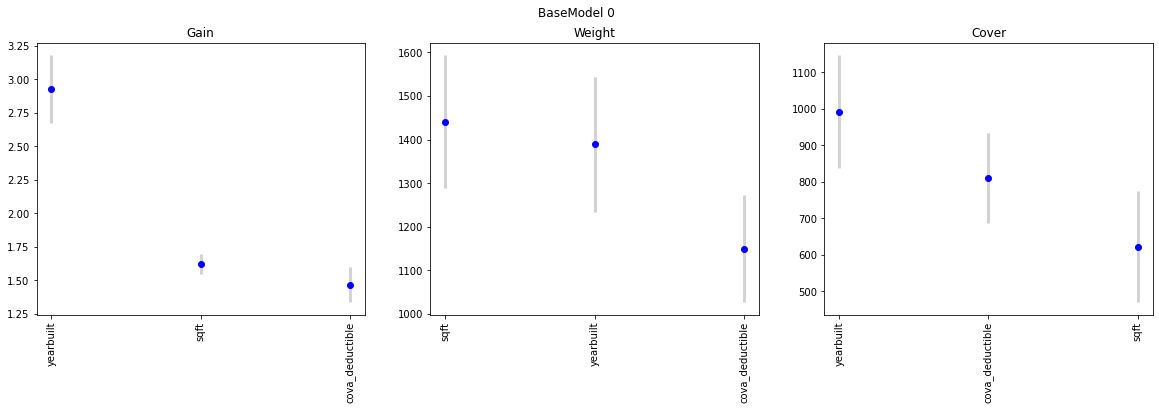

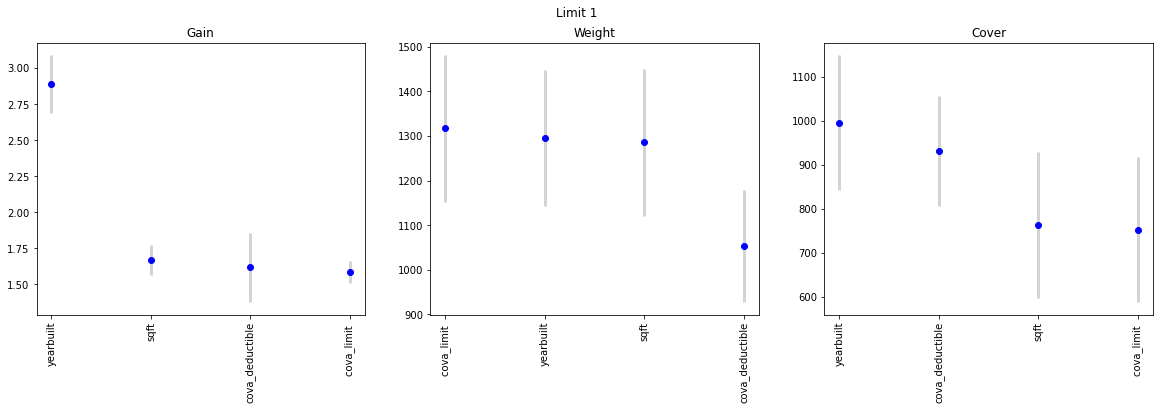

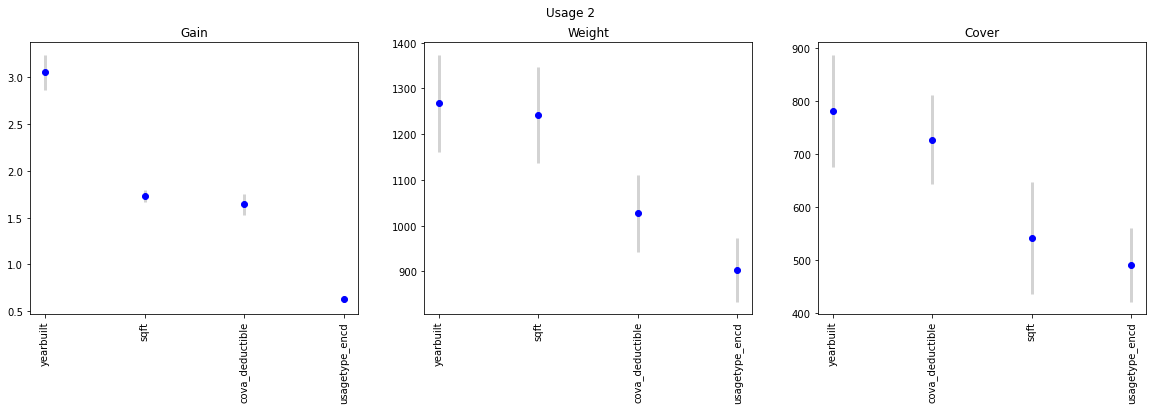

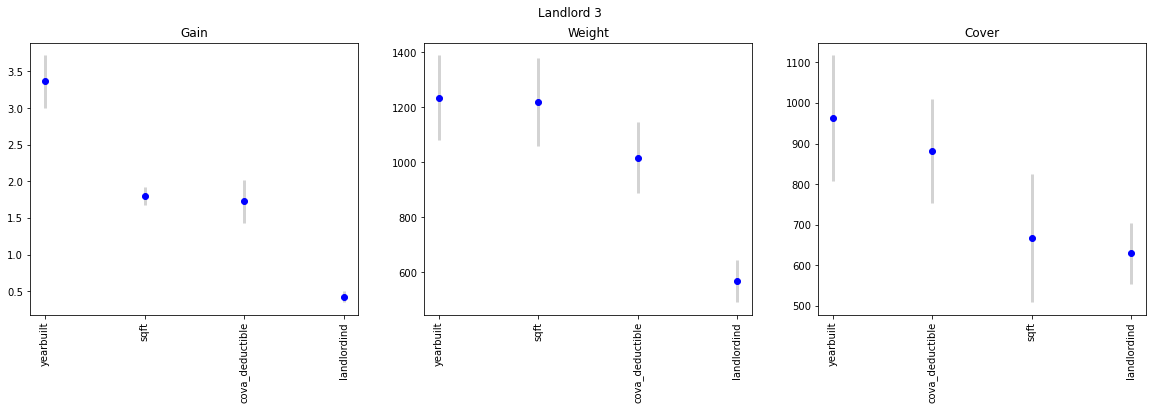

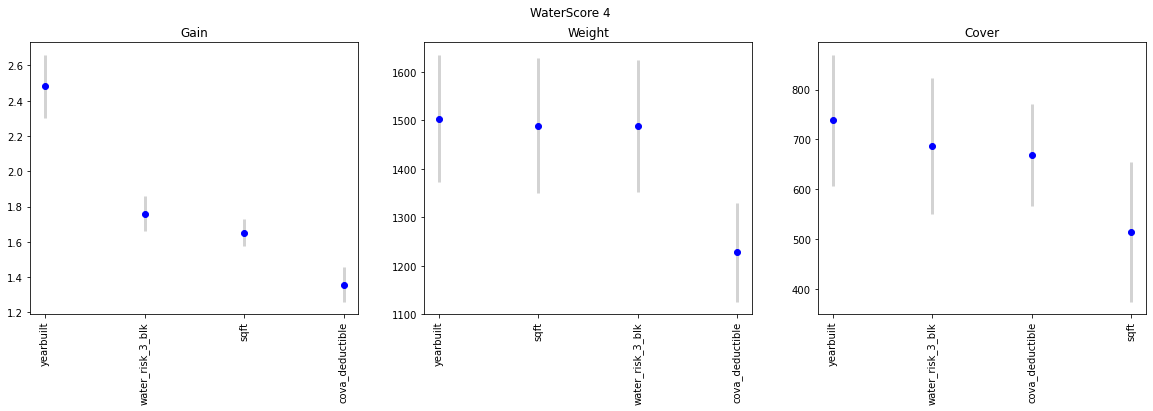

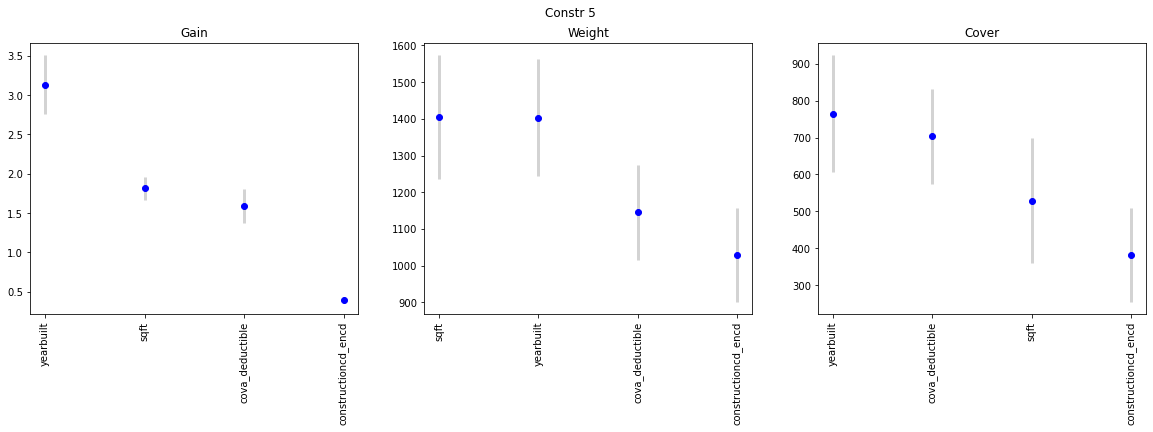

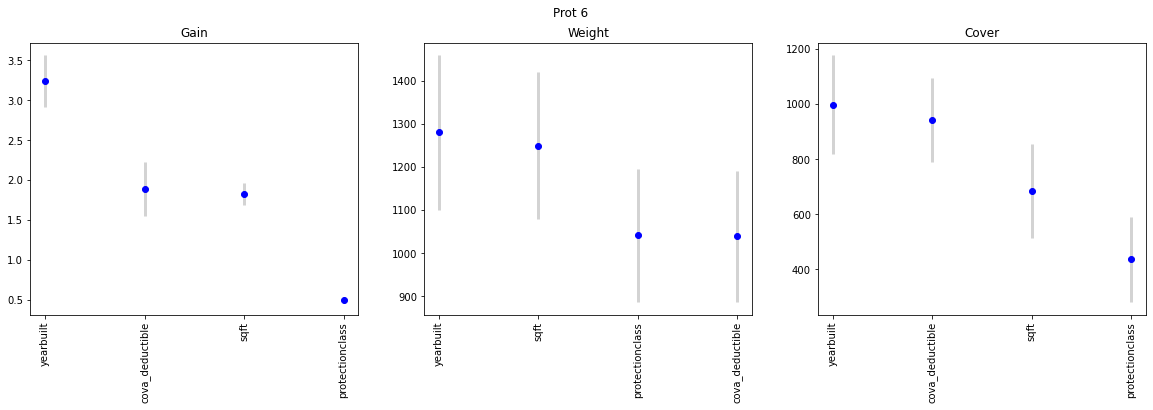

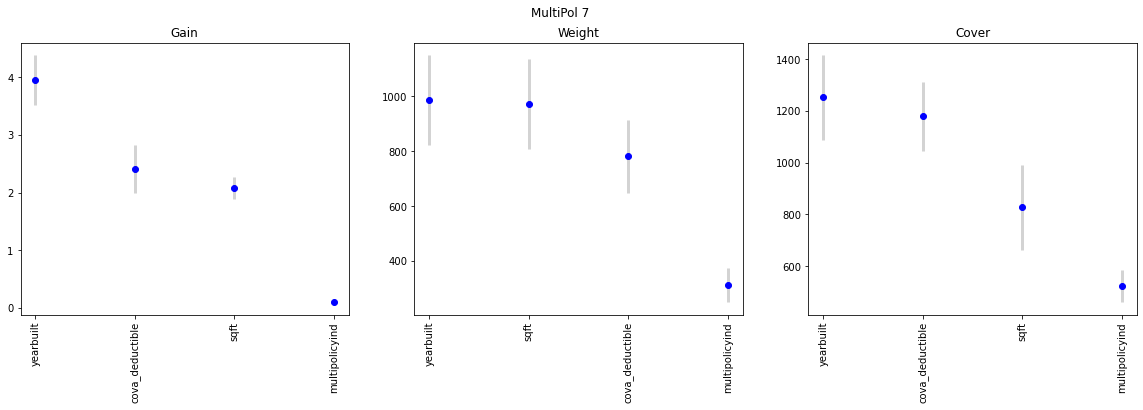

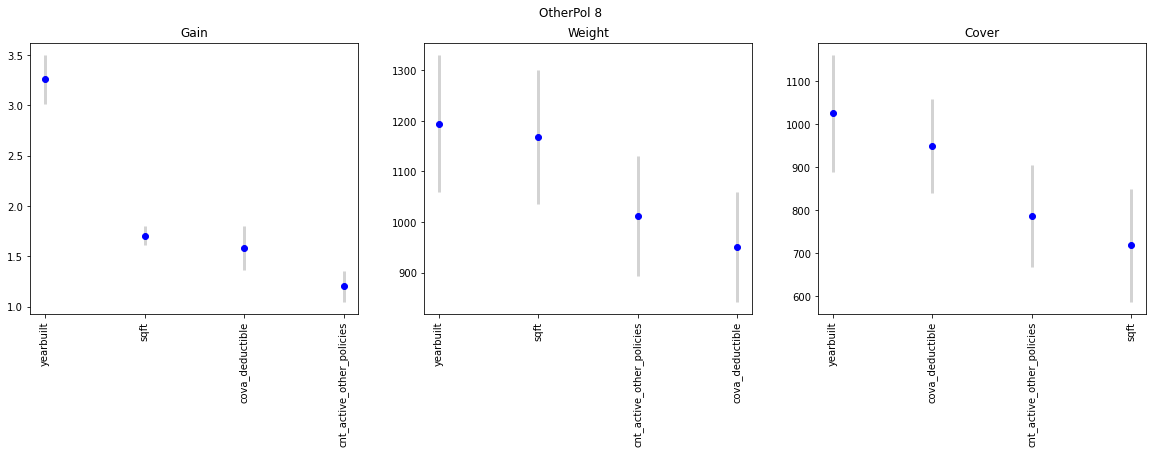

In [174]:
if len(FI):
    for index, row in model_params.iterrows():
        if len(FI[( (FI['Model']==row['Model']) & (FI['ind']==index))])>0:
            data=FI[( (FI['Model']==row['Model']) & (FI['ind']==index))].sort_values('gain-mean',ascending=False)
            fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(20,5)) 
            fig.suptitle('%s %s'%(row['Model'],index))
                
            ax = axs[0]
            ax.errorbar(data['feature'], data['gain-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['gain-sem'], fmt='o')
            ax.set_title('Gain')
            ax.set_xticklabels(data['feature'].values,rotation=90)
           
 
            data=data.sort_values('weight-mean',ascending=False)
            ax = axs[1]
            ax.errorbar(data['feature'], data['weight-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
            ax.set_title('Weight')
            ax.set_xticklabels(data['feature'].values,rotation=90)
                         
            data=data.sort_values('cover-mean',ascending=False)
            ax = axs[2]
            ax.errorbar(data['feature'], data['cover-mean'], color = 'blue',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['weight-sem'], fmt='o')
            ax.set_title('Cover')
            ax.set_xticklabels(data['feature'].values,rotation=90)

4.Training and validation errors from folds: averaging

In [66]:
#Pivoting and averaging evaluation results by fold
CVResults=ModelEvalResults.copy()
CVResults['ind']=pd.to_numeric(pd.cut(CVResults['ind'],bins=bins,labels=bin_labels))
CVResults['index'] = CVResults.index
CVResults = pd.pivot_table(CVResults, index=['index','Model','ind'], columns=['fold'])
#folds for teh same parameters and features can have different length of training
CVResults = CVResults.dropna()
CVResults.reset_index( drop=False, inplace=True )
CVResults.columns = CVResults.columns.droplevel(0)
CVResults.columns =['index','Model','ind']+folds_train_columns+folds_valid_columns
CVResults = CVResults.drop('index', axis=1)
CVResults['train-auc-mean']=CVResults[folds_train_columns].mean(axis=1)
CVResults['train-auc-std']=CVResults[folds_train_columns].std(axis=1)
CVResults['train-auc-sem']=CVResults[folds_train_columns].sem(axis=1)

CVResults['valid-auc-mean']=CVResults[folds_valid_columns].mean(axis=1)
CVResults['valid-auc-std']=CVResults[folds_valid_columns].std(axis=1)
CVResults['valid-auc-sem']=CVResults[folds_valid_columns].sem(axis=1)
CVResults = CVResults.drop(folds_valid_columns, axis=1)
CVResults = CVResults.drop(folds_train_columns, axis=1)
CVResults.tail()

,Model,ind,train-auc-mean,train-auc-std,train-auc-sem,valid-auc-mean,valid-auc-std,valid-auc-sem
3983,WaterScore,4,0.701541,0.001369,0.000433,0.685098,0.013021,0.004118
3984,WaterScore,4,0.701578,0.001367,0.000432,0.685101,0.013019,0.004117
3985,WaterScore,4,0.701610,0.001374,0.000434,0.685124,0.013026,0.004119
3986,WaterScore,4,0.701626,0.001370,0.000433,0.685145,0.013046,0.004125
3987,WaterScore,4,0.701651,0.001375,0.000435,0.685152,0.013046,0.004126


5.Visualization aggregated from folds model scores

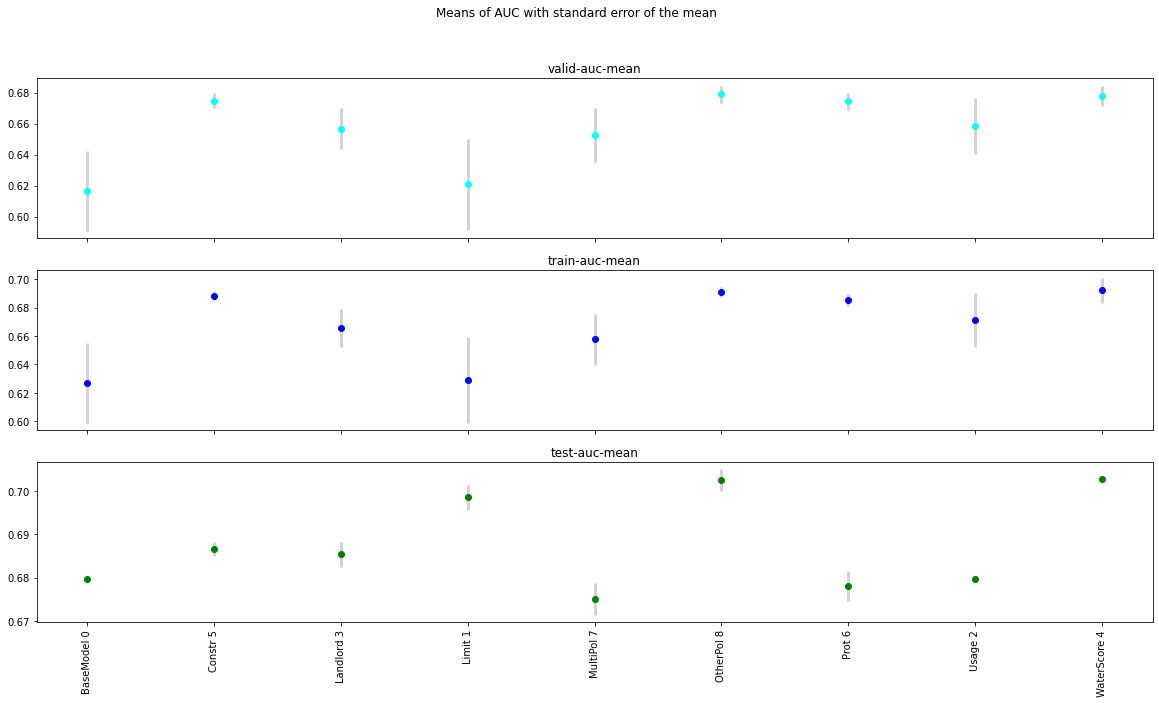

In [67]:
#Excluding from chart models which did not learn anything (0.5 is random guessing)
data = BestResults[BestResults['valid-auc-mean']>0.5].copy()
if len(ModelsTestScores)>0:
    data_test = ModelsTestScores[ModelsTestScores['test-auc-mean']>0.5].copy()
#list of models for xticks
data['xticks']=data['Model']+' '+data['ind'].astype(str) 
xticks=data['xticks'].unique().tolist()


# The x position 
r1 = np.arange(len(data))
if len(ModelsTestScores)>0:
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True,figsize=(20,10))
else:
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(20,10))
ax = axs[0]
ax.errorbar(r1, data['valid-auc-mean'], color = 'cyan',  ecolor='lightgray', elinewidth=3, capsize=0,yerr=data['valid-auc-sem'], fmt='o')
ax.set_title('valid-auc-mean')
ax = axs[1]
ax.errorbar(r1, data['train-auc-mean'],  color = 'blue',  ecolor='lightgray', elinewidth=3,capsize=0, yerr=data['train-auc-sem'],  fmt='o')
ax.set_title('train-auc-mean')
ax.set_xticks([r  for r in range(len(data))])
ax.set_xticklabels(xticks,rotation=90)
fig.suptitle('Means of AUC with standard error of the mean')
if len(data_test)>0:
    ax = axs[2]
    ax.errorbar(r1, data_test['test-auc-mean'],  color = 'green',  ecolor='lightgray', elinewidth=3,capsize=0, yerr=data_test['test-auc-sem'],  fmt='o')
    ax.set_title('test-auc-mean')
    ax.set_xticks([r  for r in range(len(data_test))])
    ax.set_xticklabels(xticks,rotation=90)

6. t-test
Compares the scores of individual folds in a choosen model to the rest of the models folds

In [83]:
#set a specific BaseModel name and index or just select with min or max score
#The rest of the models will be compared to baseModel and baseind
BaseModel='BaseModel'
BaseInd='0'
#BaseModel=BestResults[BestResults['valid-auc-mean']==BestResults['valid-auc-mean'].max()]['Model'].values[0]
#BaseInd=BestResults[BestResults['valid-auc-mean']==BestResults['valid-auc-mean'].max()]['ind'].values[0]
BaseModelResults=BestResults[((BestResults['Model']==BaseModel) & (BestResults['ind']==BaseInd))][folds_valid_columns].values[0].tolist()

In [84]:
#init new columns for t-test results
BestResults['t-statistic']=0.000
BestResults['pvalue']=0.000
BestResults['Comment']='Base Model'

In [85]:
#t-test for each record in BestResults
for index, model in BestResults.iterrows():
    if ((model['Model']!=BaseModel) | (model['ind']!=BaseInd)):
        AnalyzedModelResults=model[folds_valid_columns].values.tolist()
        t=stats.ttest_ind(BaseModelResults,AnalyzedModelResults)
        BestResults.at[index,'t-statistic']= t.statistic
        BestResults.at[index,'pvalue'] = t.pvalue 
        if t.pvalue>=confidence_level:
            BestResults.at[index,'Comment'] = 'No difference with %s with %s confidence level'%(BaseModel,confidence_level)
        else:
            BestResults.at[index,'Comment'] = 'There is a difference with %s with %s confidence level'%(BaseModel,confidence_level)
BestResults

,Model,ind,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,train-6-fold,train-7-fold,...,valid-6-fold,valid-7-fold,valid-8-fold,valid-9-fold,valid-auc-mean,valid-auc-std,valid-auc-sem,t-statistic,pvalue,Comment
0,BaseModel,0,0.68020,0.68278,0.67368,0.50000,0.69009,0.50000,0.66148,0.69460,...,0.66425,0.67371,0.50000,0.66236,0.616611,0.081843,0.025881,0.000000,0.000000,Base Model
1,Constr,5,0.66839,0.68640,0.69966,0.69595,0.69395,0.68868,0.67214,0.69530,...,0.66903,0.67530,0.66461,0.66231,0.674716,0.015240,0.004819,-2.207136,0.040528,There is a difference with BaseModel with 0.05...
2,Landlord,3,0.68403,0.69060,0.69505,0.68849,0.66692,0.68607,0.68545,0.68928,...,0.66787,0.67629,0.57437,0.59419,0.656839,0.041019,0.012971,-1.389581,0.181606,No difference with BaseModel with 0.05 confide...
3,Limit,1,0.69367,0.50000,0.59019,0.71108,0.69758,0.69071,0.50000,0.70428,...,0.50000,0.67591,0.66846,0.50000,0.620774,0.092179,0.029149,-0.106795,0.916133,No difference with BaseModel with 0.05 confide...
4,MultiPol,7,0.68070,0.50000,0.68916,0.67062,0.65646,0.68485,0.67890,0.68975,...,0.67216,0.67339,0.65664,0.65077,0.652738,0.055761,0.017633,-1.153586,0.263758,No difference with BaseModel with 0.05 confide...
5,OtherPol,8,0.69186,0.68690,0.70011,0.69745,0.69753,0.67728,0.69282,0.69869,...,0.67746,0.68824,0.66552,0.65770,0.678834,0.016744,0.005295,-2.355399,0.030048,There is a difference with BaseModel with 0.05...
6,Prot,6,0.68548,0.69119,0.69814,0.66756,0.69156,0.69596,0.67501,0.69615,...,0.67293,0.67903,0.66859,0.65043,0.674279,0.016961,0.005364,-2.181826,0.042622,There is a difference with BaseModel with 0.05...
7,Usage,2,0.50000,0.69173,0.69821,0.69256,0.69112,0.68800,0.68675,0.69542,...,0.67531,0.67948,0.66316,0.66462,0.658470,0.057757,0.018264,-1.321443,0.202905,No difference with BaseModel with 0.05 confide...
8,WaterScore,4,0.61966,0.70404,0.71485,0.71264,0.69098,0.69110,0.67908,0.71124,...,0.67422,0.68519,0.67440,0.67318,0.677794,0.020939,0.006622,-2.290232,0.034299,There is a difference with BaseModel with 0.05...


In [86]:
#joining the results of the experiment with the experiment configuration
BestResults = pd.concat([BestResults, model_params.drop('Model',axis=1)], axis=1)
BestResults = pd.merge(BestResults, model_features, on=['Model'], how='inner')
BestResults

,Model,ind,train-0-fold,train-1-fold,train-2-fold,train-3-fold,train-4-fold,train-5-fold,train-6-fold,train-7-fold,...,colsample_bylevel,colsample_bytree,eta,subsample,max_depth,num_round,F1,F2,F3,F4
0,BaseModel,0,0.68020,0.68278,0.67368,0.50000,0.69009,0.50000,0.66148,0.69460,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,NaN
1,Constr,5,0.66839,0.68640,0.69966,0.69595,0.69395,0.68868,0.67214,0.69530,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,constructioncd_encd
2,Landlord,3,0.68403,0.69060,0.69505,0.68849,0.66692,0.68607,0.68545,0.68928,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,landlordind
3,Limit,1,0.69367,0.50000,0.59019,0.71108,0.69758,0.69071,0.50000,0.70428,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,cova_limit
4,MultiPol,7,0.68070,0.50000,0.68916,0.67062,0.65646,0.68485,0.67890,0.68975,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,multipolicyind
5,OtherPol,8,0.69186,0.68690,0.70011,0.69745,0.69753,0.67728,0.69282,0.69869,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,cnt_active_other_policies
6,Prot,6,0.68548,0.69119,0.69814,0.66756,0.69156,0.69596,0.67501,0.69615,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,protectionclass
7,Usage,2,0.50000,0.69173,0.69821,0.69256,0.69112,0.68800,0.68675,0.69542,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,usagetype_encd
8,WaterScore,4,0.61966,0.70404,0.71485,0.71264,0.69098,0.69110,0.67908,0.71124,...,0.6,0.8,0.02,0.6,3,5000,yearbuilt,cova_deductible,sqft,water_risk_3_blk


In [87]:
#Saving into the Experiment log file models results
eu.SaveToExperimentLog(Experiments_file, '%s BestResults'%Experiment_name, BestResults)

7. Training and validation errors (output from the model) to estimate overfitting

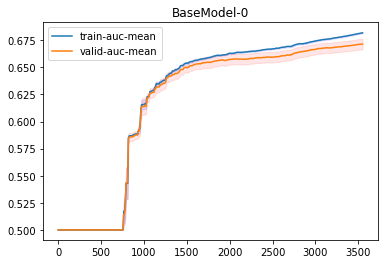

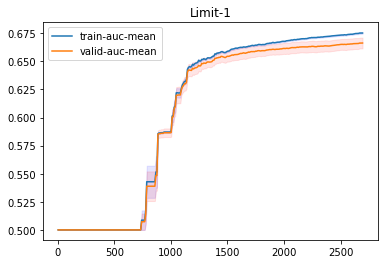

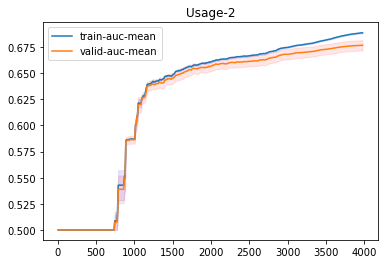

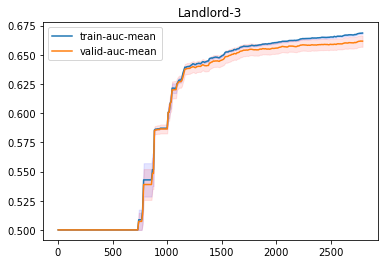

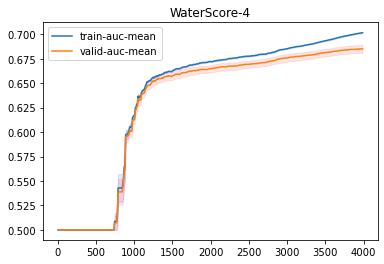

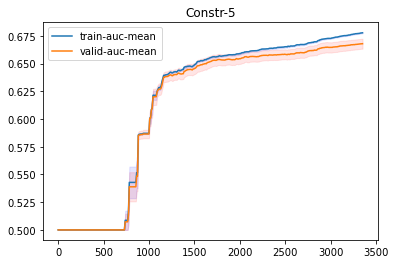

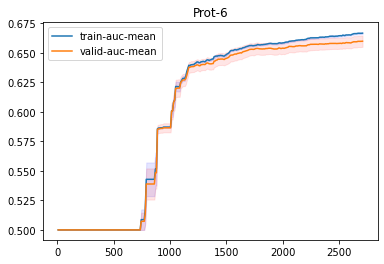

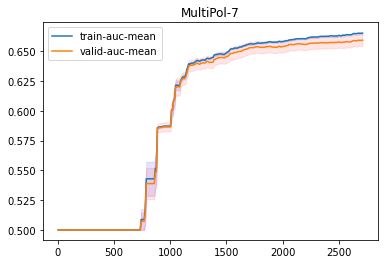

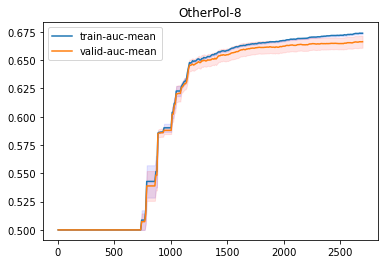

In [88]:
for index, row in model_params.iterrows():
    if len(CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))])>0:
        data=CVResults[( (CVResults['Model']==row['Model']) & (CVResults['ind']==index))]
        ax=data[['train-auc-mean','valid-auc-mean']].plot(title=row['Model']+'-'+str(index))
        ax.fill_between(data.index.values, (data['train-auc-mean'].values-data['train-auc-sem'].values), (data['train-auc-mean'].values + data['train-auc-sem'].values), color='b', alpha=.1)
        ax.fill_between(data.index.values, (data['valid-auc-mean'].values-data['valid-auc-sem'].values), (data['valid-auc-mean'].values + data['valid-auc-sem'].values), color='r', alpha=.1)
        
  

In [ ]:
#Saving into the Experiment log file models results
#eu.SaveToExperimentLog(Experiments_file, '%s CVResults'%Experiment_name, CVResults)

In [90]:
#Saving models artifacts into the Experiment Log file
ModelsFiles=trial_ds[['Model','fold','ind','SageMaker.ModelArtifact - Value']]
ModelsFiles.columns=['Model','fold','ind','ModelFile']
ModelsFiles=ModelsFiles.sort_values(['Model','ind','fold'], ascending=[False,True,True])
ModelsFiles['ind']=pd.cut(ModelsFiles['ind'],bins=bins,labels=bin_labels)
eu.SaveToExperimentLog(Experiments_file, '%s ModelFiles'%Experiment_name, ModelsFiles)